# Multi-Touch Attribution

## Rule-based MTA

In [ ]:
import pandas as pd
from itertools import chain, tee, combinations
from functools import reduce, wraps
from operator import mul
from collections import defaultdict, Counter
import random
import time
import numpy as np
import copy
import json
import os

import arrow

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
#Preprocessing
 
df_raw = pd.read_csv('dataset1.csv')
df = df_raw.copy()

#converting touchpoints to journeys for each customer
df = df.groupby('customer_id')[['channel','conversion']].agg(lambda x : x.sum() if x.dtype=='int64' else ' > '.join(x))

df['path_no'] = df.groupby('customer_id')['conversion'].cumsum(skipna=True)#.unstack()

#selecting only first conversion journeys
df = df[(df['path_no']==0) | (df['path_no']==1)]
df.drop('path_no', axis=1, inplace=True)

df['non_conversion'] = 0
df.loc[df['conversion']==0,'non_conversion']=1

df = df.groupby('channel').sum().sort_values(by='conversion', ascending=False).reset_index()
df.head()

,channel,conversion,non_conversion
0,Paid_Search > Adwords_Display > Website > Paid...,5,13
1,Paid_Search > Facebook_Ads > Website > Website,4,14
2,Facebook_Ads > Website > Paid_Search > Website,4,8
3,Adwords_Display > Paid_Search > Google_Search ...,4,3
4,Paid_Search > Website > Website > Other_Digital,3,3


In [ ]:
def normalize_dict(d):
    """
    returns a value-normalized version of dictionary d
    """
    sum_all_values = sum(d.values())

    for _ in d:
        d[_] = round(d[_]/sum_all_values, 6)

    return d

In [ ]:
NULL = '(null)'
START = '(start)'
CONV = '(conversion)'
channels = df_raw.channel.unique().tolist()
channels_ext = [START] + channels + [CONV, NULL]
c2i = {c: i for i, c in enumerate(channels_ext)}
i2c = {i: c for c, i in c2i.items()}

removal_effects = defaultdict(float)

data = df.copy()

sep = '>'
data['channel'] = data['channel'].apply(lambda _: [ch.strip() for ch in _.split(sep.strip())])

## Rule-based Modeling

In [ ]:
def pairs(lst):
    it1, it2 = tee(lst)
    next(it2, None)
    return zip(it1, it2)

In [ ]:
def first_touch(normalize=True):
    first_touch = defaultdict(int)
    for c in channels:
        # total conversions for all paths where the first channel was c
        first_touch[c] = data.loc[data['channel'].apply(lambda _: _[0] == c), 'conversion'].sum()

    if normalize:
        first_touch = normalize_dict(first_touch)

    return first_touch

first_touch()

defaultdict(int,
            {'Adwords_Display': 0.136861,
             'Google_Search': 0.109489,
             'Website': 0.258516,
             'Facebook_Ads': 0.124696,
             'Other_Digital': 0.074209,
             'Email': 0.06326,
             'Paid_Search': 0.204988,
             'Online_Referrals': 0.027981})

In [ ]:
def last_touch(normalize=True):

    last_touch = defaultdict(int)

    for c in channels:

        # total conversions for all paths where the last channel was c
        last_touch[c] = data.loc[data['channel'].apply(lambda _: _[-1] == c), 'conversion'].sum()

    if normalize:
        last_touch = normalize_dict(last_touch)

    return last_touch

last_touch()

defaultdict(int,
            {'Adwords_Display': 0.149635,
             'Google_Search': 0.093066,
             'Website': 0.265815,
             'Facebook_Ads': 0.116788,
             'Other_Digital': 0.075426,
             'Email': 0.079684,
             'Paid_Search': 0.190998,
             'Online_Referrals': 0.028589})

In [ ]:
def linear(share='same', normalize=True):

    if share not in 'same proportional'.split():
        raise ValueError('share parameter must be either *same* or *proportional*!')

    linear = defaultdict(float)

    for row in data.itertuples():
        if row.conversion:
            if share == 'same':
                n = len(set(row.channel))    # number of unique channels visited during the journey
                s = row.conversion/n    # each channel is getting an equal share of conversions
                for c in set(row.channel):
                    linear[c] += s

            elif share == 'proportional':
                c_counts = Counter(row.channel)  # count how many times channels appear on this path
                tot_appearances = sum(c_counts.values())
                c_shares = defaultdict(float)
                for c in c_counts:
                    c_shares[c] = c_counts[c]/tot_appearances
                for c in set(row.channel):

                    linear[c] += row.conversion*c_shares[c]

    if normalize:
        linear = normalize_dict(linear)

    return linear

linear()

defaultdict(float,
            {'Adwords_Display': 0.152698,
             'Website': 0.198227,
             'Paid_Search': 0.176592,
             'Facebook_Ads': 0.128625,
             'Google_Search': 0.119486,
             'Other_Digital': 0.087125,
             'Email': 0.094443,
             'Online_Referrals': 0.042804})

In [ ]:
def time_decay(count_direction='left', normalize=True):

    """
    time decay - the closer to conversion was exposure to a channel, the more credit this channel gets

    this can work differently depending how you get timing sorted. 

    example: a > b > c > b > a > c > (conversion)

    we can count timing backwards: c the latest, then a, then b (lowest credit) and done. Or we could count left to right, i.e.
    a first (lowest credit), then b, then c. 

    """

    time_decay = defaultdict(float)

    if count_direction not in 'left right'.split():
        raise ValueError('argument count_direction must be *left* or *right*!')

    for row in data.itertuples():

        if row.conversion:

            channels_by_exp_time = []

            _ = row.channel if count_direction == 'left' else row.channel[::-1]

            for c in _:
                if c not in channels_by_exp_time:
                    channels_by_exp_time.append(c)

            if count_direction == 'right':
                channels_by_exp_time = channels_by_exp_time[::-1]

            # first channel gets 1, second 2, etc.

            score_unit = 1./sum(range(1, len(channels_by_exp_time) + 1))

            for i, c in enumerate(channels_by_exp_time, 1):
                time_decay[c] += i*score_unit*row.conversion

    if normalize:
        time_decay = normalize_dict(time_decay)

    return time_decay

time_decay()

defaultdict(float,
            {'Paid_Search': 0.16629,
             'Adwords_Display': 0.152838,
             'Website': 0.183823,
             'Facebook_Ads': 0.128767,
             'Google_Search': 0.123452,
             'Other_Digital': 0.094804,
             'Email': 0.102825,
             'Online_Referrals': 0.047201})

## Markov Chain MTA

In [ ]:
import pandas as pd
from itertools import chain, tee, combinations
from functools import reduce, wraps
from operator import mul
from collections import defaultdict, Counter
import random
import time
import numpy as np
import copy
import json
import os

import arrow

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
df_raw = pd.read_csv('dataset1.csv')
df_raw.head()

,customer_id,date,channel,conversion
0,id10,1/1/2016,Adwords_Display,0
1,id10,1/1/2016,Google_Search,0
2,id10,1/2/2016,Website,0
3,id10,1/3/2016,Facebook_Ads,0
4,id10,1/3/2016,Other_Digital,0


In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
customer_id    80000 non-null object
date           80000 non-null object
channel        80000 non-null object
conversion     80000 non-null int64
dtypes: int64(1), object(3)
memory usage: 2.4+ MB


In [ ]:
df = df_raw.copy()

## Preprocessing

In [ ]:
df['path_no'] = df.groupby('customer_id')['conversion'].cumsum(skipna=True)#.unstack()
df.head()

,customer_id,date,channel,conversion,path_no
0,id10,1/1/2016,Adwords_Display,0,0
1,id10,1/1/2016,Google_Search,0,0
2,id10,1/2/2016,Website,0,0
3,id10,1/3/2016,Facebook_Ads,0,0
4,id10,1/3/2016,Other_Digital,0,0


In [ ]:
#selecting only first conversion journeys
df = df[(df['path_no']==0) | (df['path_no']==1)]
df.drop('path_no', axis=1, inplace=True)
df.head()

,customer_id,date,channel,conversion
0,id10,1/1/2016,Adwords_Display,0
1,id10,1/1/2016,Google_Search,0
2,id10,1/2/2016,Website,0
3,id10,1/3/2016,Facebook_Ads,0
4,id10,1/3/2016,Other_Digital,0


In [ ]:
#converting touchpoints to journeys for each customer
df = df.groupby('customer_id')[['channel','conversion']].agg(lambda x : x.sum() if x.dtype=='int64' else ' > '.join(x))
df.head()

,channel,conversion
customer_id,,
id10,Adwords_Display > Google_Search > Website > Fa...,0
id100,Email > Email > Website > Google_Search > Webs...,0
id10000,Google_Search > Email > Adwords_Display > Website,0
id10003,Paid_Search > Google_Search > Website > Online...,0
id10005,Website > Adwords_Display > Website > Website,0


In [ ]:
df['non_conversion'] = 0
df.loc[df['conversion']==0,'non_conversion']=1
df.head()

,channel,conversion,non_conversion
customer_id,,,
id10,Adwords_Display > Google_Search > Website > Fa...,0,1
id100,Email > Email > Website > Google_Search > Webs...,0,1
id10000,Google_Search > Email > Adwords_Display > Website,0,1
id10003,Paid_Search > Google_Search > Website > Online...,0,1
id10005,Website > Adwords_Display > Website > Website,0,1


In [ ]:
df_uniquePath = df.groupby('channel').sum().sort_values(by='conversion', ascending=False).reset_index()
df_uniquePath.head()

,channel,conversion,non_conversion
0,Paid_Search > Adwords_Display > Website > Paid...,5,13
1,Paid_Search > Facebook_Ads > Website > Website,4,14
2,Adwords_Display > Paid_Search > Google_Search ...,4,3
3,Facebook_Ads > Website > Paid_Search > Website,4,8
4,Facebook_Ads > Google_Search > Paid_Search > W...,3,3


## EDA

In [ ]:
df_raw.conversion = df_raw.conversion.astype('object')
df_raw.describe()

,customer_id,date,channel,conversion
count,80000,80000,80000,80000
unique,12658,63,8,2
top,id17911,1/1/2016,Website,0
freq,28,16731,19994,78025


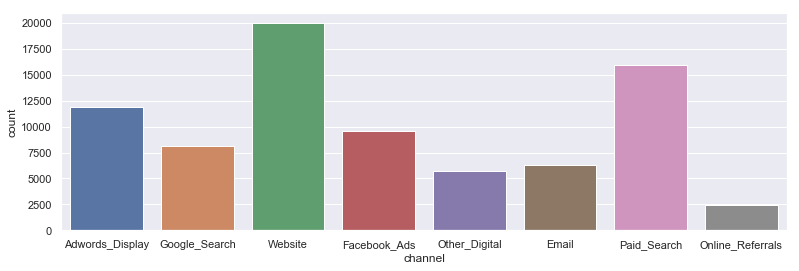

In [ ]:
sns.set(rc={'figure.figsize':(13,4)})
sns.countplot(df_raw['channel'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12658 entries, id10 to id9999
Data columns (total 3 columns):
channel           12658 non-null object
conversion        12658 non-null int64
non_conversion    12658 non-null int64
dtypes: int64(2), object(1)
memory usage: 395.6+ KB


0    10858
1     1800
Name: conversion, dtype: int64

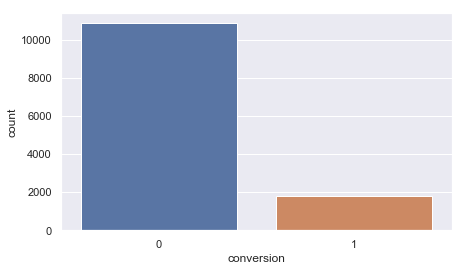

In [ ]:
sns.set(rc={'figure.figsize':(7,4)})
sns.countplot('conversion', data=df)
df.conversion.value_counts(dropna=False)

In [ ]:
def normalize_dict(d):
    """
    returns a value-normalized version of dictionary d
    """
    sum_all_values = sum(d.values())

    for _ in d:
        d[_] = round(d[_]/sum_all_values, 6)

    return d

## Markov Modeling

In [ ]:
NULL = '(null)'
START = '(start)'
CONV = '(conversion)'
channels = df_raw.channel.unique().tolist()
channels_ext = [START] + channels + [CONV, NULL]
c2i = {c: i for i, c in enumerate(channels_ext)}
i2c = {i: c for c, i in c2i.items()}

removal_effects = defaultdict(float)

data = df.copy()

sep = '>'
data['channel'] = data['channel'].apply(lambda _: [ch.strip() for ch in _.split(sep.strip())])

In [ ]:
def pairs(lst):
    it1, it2 = tee(lst)
    next(it2, None)
    return zip(it1, it2)

In [ ]:
def count_pairs():

    """
    count how many times channel pairs appear on all recorded customer journey paths
    """

    c = defaultdict(int)

    for row in data.itertuples():

        for ch_pair in pairs([START] + row.channel):
            c[ch_pair] += (row.conversion + row.non_conversion)

        c[(row.channel[-1], NULL)] += row.non_conversion
        c[(row.channel[-1], CONV)] += row.conversion

    return c

In [ ]:
def ordered_tuple(self, t):

    """
    return tuple t ordered 
    """

    if not isinstance(t, tuple):
        raise TypeError(f'provided value {t} is not tuple!')

    if all([len(t) == 1, t[0] in '(start) (null) (conversion)'.split()]):
        raise Exception(f'wrong transition {t}!')

    if (len(t) > 1) and (t[-1] == self.START): 
        raise Exception(f'wrong transition {t}!')

    if (len(t) > 1) and (t[0] == self.START):
        return (t[0],) + tuple(sorted(list(t[1:])))

    if (len(t) > 1) and (t[-1] in '(null) (conversion)'.split()):
        return tuple(sorted(list(t[:-1]))) + (t[-1],)

    return tuple(sorted(list(t)))

In [ ]:
def trans_matrix():

        """
        calculate transition matrix which will actually be a dictionary mapping 
        a pair (a, b) to the probability of moving from a to b, e.g. T[(a, b)] = 0.5
        """

        tr = defaultdict(float)

        outs = defaultdict(int)

        # here pairs are unordered
        pair_counts = count_pairs()

        for pair in pair_counts:

            outs[pair[0]] += pair_counts[pair]

        for pair in pair_counts:

            tr[pair] = pair_counts[pair]/outs[pair[0]]

        return tr

In [ ]:
def simulate_path(trans_mat, drop_channel=None, n=int(1e6)):

    """
    generate n random user journeys and see where these users end up - converted or not;
    drop_channel is a channel to exclude from journeys if specified
    """

    outcome_counts = defaultdict(int)

    idx0 = c2i[START]
    null_idx = c2i[NULL]
    conv_idx = c2i[CONV]

    drop_idx = c2i[drop_channel] if drop_channel else null_idx

    for _ in range(n):

        stop_flag = None

        while not stop_flag:

            probs = [trans_mat.get((i2c[idx0], i2c[i]), 0) for i in range(len(channels_ext))]

            # index of the channel where user goes next
            idx1 = np.random.choice([c2i[c] for c in channels_ext], p=probs, replace=False)

            if idx1 == conv_idx:
                outcome_counts[CONV] += 1
                stop_flag = True
            elif idx1 in {null_idx, drop_idx}:
                outcome_counts[NULL] += 1
                stop_flag = True
            else:
                idx0 = idx1

    return outcome_counts

In [ ]:
def prob_convert(trans_mat, drop='None'):
    _d = data[data['channel'].apply(lambda x: drop not in x) & (data['conversion'] > 0)]

    p = 0

    for row in _d.itertuples():

        pr_this_path = []

        for t in pairs([START] + row.channel + [CONV]):
            pr_this_path.append(trans_mat.get(t, 0))

        p += reduce(mul, pr_this_path)

    return p

In [ ]:
def markov(sim=False, normalize=False):

    markov = defaultdict(float)

    # calculate the transition matrix
    tr = trans_matrix()

    if not sim:
        p_conv = prob_convert(trans_mat=tr)
        for c in channels:
            markov[c] = (p_conv - prob_convert(trans_mat=tr, drop=c))/p_conv
    else:
        outcomes = defaultdict(lambda: defaultdict(float))
        # get conversion counts when all chennels are in place
        outcomes['full'] = simulate_path(trans_mat=tr, drop_channel=None)
        for c in channels:
            outcomes[c] = simulate_path(trans_mat=tr, drop_channel=c)
            # removal effect for channel c
            markov[c] = (outcomes['full'][CONV] - outcomes[c][CONV])/outcomes['full'][CONV]

    if normalize:
        markov = normalize_dict(markov)
    
    return markov

In [ ]:
markov(normalize=True)

defaultdict(float,
            {'Adwords_Display': 0.173806,
             'Google_Search': 0.082888,
             'Website': 0.418045,
             'Facebook_Ads': 0.145561,
             'Other_Digital': 0.044775,
             'Email': 0.02442,
             'Paid_Search': 0.108041,
             'Online_Referrals': 0.002464})

## Survival Model MTA

In [ ]:
import pandas as pd
from itertools import chain, tee, combinations
from functools import reduce, wraps
from operator import mul
from collections import defaultdict, Counter
import random
import time
import numpy as np
import copy
import json
import os

import arrow

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
#Preprocessing
 
df_raw = pd.read_csv('dataset1.csv')
df = df_raw.copy()

#converting touchpoints to journeys for each customer
df = df.groupby('customer_id')[['channel','conversion']].agg(lambda x : x.sum() if x.dtype=='int64' else ' > '.join(x))

df['path_no'] = df.groupby('customer_id')['conversion'].cumsum(skipna=True)#.unstack()

#selecting only first conversion journeys
df = df[(df['path_no']==0) | (df['path_no']==1)]
df.drop('path_no', axis=1, inplace=True)

df['non_conversion'] = 0
df.loc[df['conversion']==0,'non_conversion']=1

df.head()

,channel,conversion,non_conversion
0,Paid_Search > Adwords_Display > Website > Paid...,5,13
1,Paid_Search > Facebook_Ads > Website > Website,4,14
2,Facebook_Ads > Website > Paid_Search > Website,4,8
3,Adwords_Display > Paid_Search > Google_Search ...,4,3
4,Paid_Search > Website > Website > Other_Digital,3,3


In [ ]:
channels = df_raw.channel.unique().tolist()
data = df.copy()
sep = '>'
data['channel'] = data['channel'].apply(lambda _: [ch.strip() for ch in _.split(sep.strip())])

In [ ]:
# Add exposure time in dataset for Additive Hazard time modeling

def add_exposure_times(dt=None):

    """
    generate synthetic exposure times; if dt is specified, the exposures will be dt=1 sec away from one another, otherwise
    we'll generate time spans randomly

    - the times are of the form 2018-11-26T03:54:26.532091+00:00
    """

    ts = []    # this will be a list of time instant lists one per path 

    if not dt:

        _t0 = arrow.utcnow()

        data['channel']\
        .apply(lambda lst: ts.append(sep.join([r.format('YYYY-MM-DD') 
                                for r in arrow.Arrow.range('day', _t0, _t0.shift(days=+(len(lst) - 1)))])))

    data['exposure_times'] = ts
    data['exposure_times'] = data['exposure_times'].apply(lambda _: [ch.strip() for ch in _.split(sep.strip())])
    return data


data = add_exposure_times()
data.head()

,channel,conversion,non_conversion,exposure_times
0,"[Paid_Search, Adwords_Display, Website, Paid_S...",5,13,"[2019-06-13, 2019-06-14, 2019-06-15, 2019-06-16]"
1,"[Paid_Search, Facebook_Ads, Website, Website]",4,14,"[2019-06-13, 2019-06-14, 2019-06-15, 2019-06-16]"
2,"[Facebook_Ads, Website, Paid_Search, Website]",4,8,"[2019-06-13, 2019-06-14, 2019-06-15, 2019-06-16]"
3,"[Adwords_Display, Paid_Search, Google_Search, ...",4,3,"[2019-06-13, 2019-06-14, 2019-06-15, 2019-06-16]"
4,"[Paid_Search, Website, Website, Other_Digital]",3,3,"[2019-06-13, 2019-06-14, 2019-06-15, 2019-06-16]"


In [ ]:
def normalize_dict(d):
    """
    returns a value-normalized version of dictionary d
    """
    sum_all_values = sum(d.values())

    for _ in d:
        d[_] = round(d[_]/sum_all_values, 6)

    return d

## Additive Hazard Modeling

In [ ]:
def pi(path, exposure_times, conv_flag, beta_by_channel, omega_by_channel):

    """

    calculate contribution of channel i to conversion of journey (user) u - (p_i^u) in the paper

     - path is a list of states that includes (start) but EXCLUDES (null) or (conversion)
     - exposure_times is list of exposure times

    """

    p = {c: 0 for c in path}    # contributions by channel

    # all contributions are zero if no conversion
    if not conv_flag:
        return p

    dts = [(arrow.get(exposure_times[-1]) - arrow.get(t)).days for t in exposure_times]

    _ = defaultdict(float)

    for c, dt in zip(path, dts):
        _[c] += beta_by_channel[c]*omega_by_channel[c]*np.exp(-omega_by_channel[c]*dt)

    for c in _:
        p[c] = _[c]/sum(_.values())

    return p

In [ ]:
def update_coefs(beta, omega):

    """
    return updated beta and omega
    """

    delta = 1e-3

    beta_num = defaultdict(float)
    beta_den = defaultdict(float)
    omega_den = defaultdict(float)

    for u, row in enumerate(data.itertuples()):

        p = pi(row.channel, row.exposure_times, row.conversion, beta, omega)

        r = copy.deepcopy(row.channel)

        dts = [(arrow.get(row.exposure_times[-1]) - arrow.get(t)).seconds for t in row.exposure_times]

        while r:

            # pick channels starting from the last one
            c = r.pop()
            dt = dts.pop()

            beta_den[c] += (1.0 - np.exp(-omega[c]*dt))
            omega_den[c] += (p[c]*dt + beta[c]*dt*np.exp(-omega[c]*dt))

            beta_num[c] += p[c]

    # now that we gone through every user, update coefficients for every channel

    beta0 = copy.deepcopy(beta)
    omega0 = copy.deepcopy(omega)

    df = []

    for c in channels:

        beta_num[c] = (beta_num[c] > 1e-6)*beta_num[c]
        beta_den[c] = (beta_den[c] > 1e-6)*beta_den[c]
        omega_den[c] = max(omega_den[c], 1e-6)

        if beta_den[c]:
            beta[c] = beta_num[c]/beta_den[c]

        omega[c] = beta_num[c]/omega_den[c]

        df.append(abs(beta[c] - beta0[c]) < delta)
        df.append(abs(omega[c] - omega0[c]) < delta)

    return (beta, omega, sum(df))

In [ ]:
def additive_hazard(epochs=20, normalize=True):

    """
    additive hazard model as in Multi-Touch Attribution in On-line Advertising with Survival Theory
    """

    beta = {c: random.uniform(0.001,1) for c in channels}
    omega = {c: random.uniform(0.001,1) for c in channels}

    for _ in range(epochs):

        beta, omega, h = update_coefs(beta, omega)

        if h == 2*len(channels):
            print(f'converged after {_ + 1} iterations')
            break

    # time window: take the max time instant across all journeys that converged

    additive_hazard = defaultdict(float)

    for u, row in enumerate(data.itertuples()):

        p = pi(row.channel, row.exposure_times, row.conversion, beta, omega)

        for c in p:
            additive_hazard[c] += p[c]

    if normalize:
        additive_hazard = normalize_dict(additive_hazard)
    
    return additive_hazard

In [ ]:
result = additive_hazard()

converged after 3 iterations


In [ ]:
result

defaultdict(float,
            {'Paid_Search': 0.18795,
             'Adwords_Display': 0.151932,
             'Website': 0.253438,
             'Facebook_Ads': 0.121153,
             'Google_Search': 0.096267,
             'Other_Digital': 0.076621,
             'Email': 0.08186,
             'Online_Referrals': 0.030779})

In [ ]:
pd.DataFrame(list(result.items()), columns=['channel','attribution']).to_csv('additiveHazardMTA.csv')

## Attribution Model Comparison Part 1/2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
path = 'attribution/'
data1 = pd.read_csv(path+'RuleAndMarkovMTA.csv', index_col=0)
data1.columns = ['channel','first_touch','last_touch','linear_touch','markov_model']
data1

,channel,first_touch,last_touch,linear_touch,markov_model
1,Adwords_Display,255,272,274.169173,267.172861
2,Email,118,145,138.266786,179.873737
3,Facebook_Ads,226,213,214.032895,232.731267
4,Google_Search,201,175,186.884932,220.790646
5,Online_Referrals,50,49,56.880465,89.681437
6,Other_Digital,131,131,126.183336,168.739718
7,Paid_Search,363,343,350.803261,304.133154
8,Website,456,472,452.779152,336.877180


In [ ]:
data2 = pd.read_csv(path+'additiveHazardMTA.csv', index_col=0)
data2.columns = ['channel','additive_hazard']
data2

,channel,additive_hazard
0,Paid_Search,0.187950
1,Adwords_Display,0.151932
2,Website,0.253438
3,Facebook_Ads,0.121153
4,Google_Search,0.096267
5,Other_Digital,0.076621
6,Email,0.081860
7,Online_Referrals,0.030779


In [ ]:
df = pd.merge(data1, data2, on=['channel'], how='inner').set_index('channel')
df

,first_touch,last_touch,linear_touch,markov_model,additive_hazard
channel,,,,,
Adwords_Display,255,272,274.169173,267.172861,0.151932
Email,118,145,138.266786,179.873737,0.081860
Facebook_Ads,226,213,214.032895,232.731267,0.121153
Google_Search,201,175,186.884932,220.790646,0.096267
Online_Referrals,50,49,56.880465,89.681437,0.030779
Other_Digital,131,131,126.183336,168.739718,0.076621
Paid_Search,363,343,350.803261,304.133154,0.187950
Website,456,472,452.779152,336.877180,0.253438


In [ ]:
for col in df.columns:
    df[col] = df[col]/df[col].sum()
df.reset_index(inplace=True)
df

,channel,first_touch,last_touch,linear_touch,markov_model,additive_hazard
0,Adwords_Display,0.141667,0.151111,0.152316,0.148429,0.151932
1,Email,0.065556,0.080556,0.076815,0.099930,0.081860
2,Facebook_Ads,0.125556,0.118333,0.118907,0.129295,0.121153
3,Google_Search,0.111667,0.097222,0.103825,0.122661,0.096267
4,Online_Referrals,0.027778,0.027222,0.031600,0.049823,0.030779
5,Other_Digital,0.072778,0.072778,0.070102,0.093744,0.076621
6,Paid_Search,0.201667,0.190556,0.194891,0.168963,0.187950
7,Website,0.253333,0.262222,0.251544,0.187154,0.253438


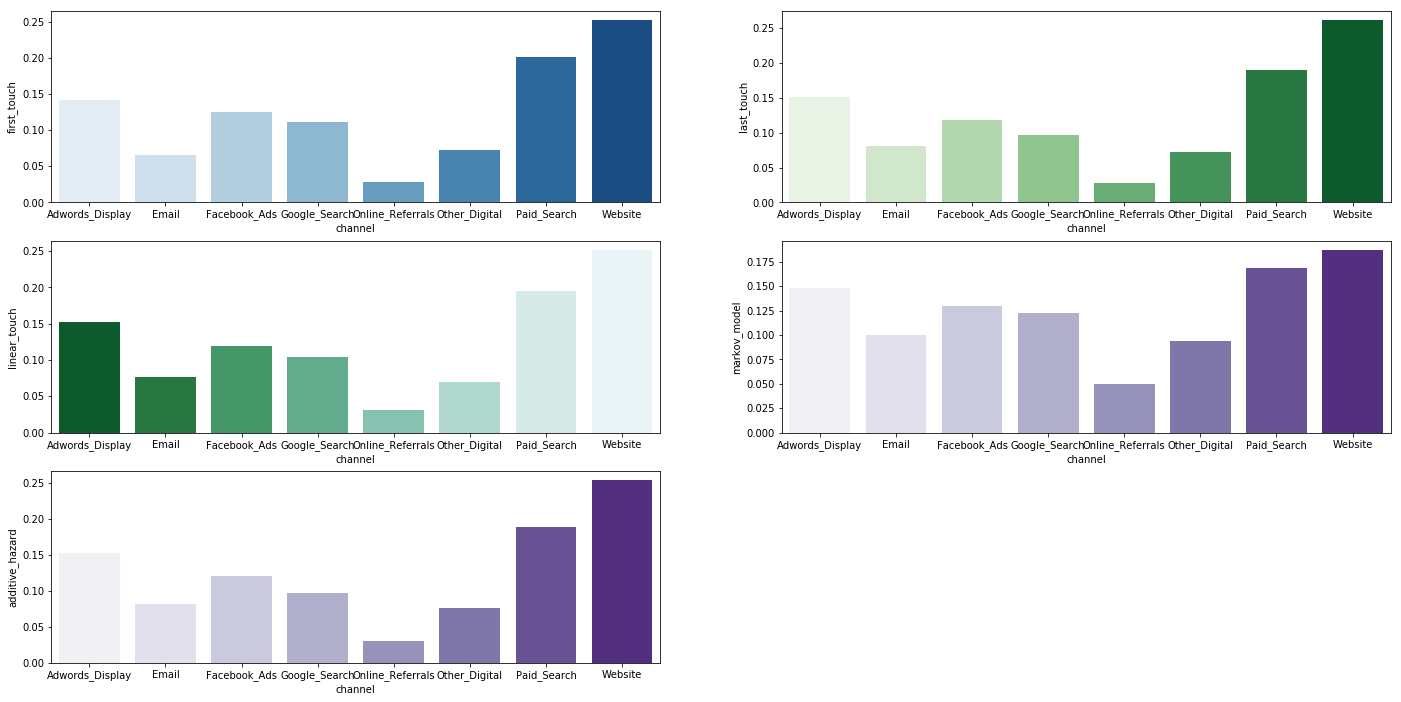

In [ ]:
f, axes = plt.subplots(3, 2, figsize=(24,12))

sns.barplot(x='channel', y='first_touch', data=df, ax=axes[0,0], palette="Blues")
sns.barplot(x='channel', y='last_touch', data=df, ax=axes[0,1], palette="Greens")
sns.barplot(x='channel', y='linear_touch', data=df, ax=axes[1,0], palette="BuGn_r")
sns.barplot(x='channel', y='markov_model', data=df, ax=axes[1,1], palette="Purples")
sns.barplot(x='channel', y='additive_hazard', data=df, ax=axes[2,0], palette="Purples")
f.delaxes(axes[2,1])
plt.show()

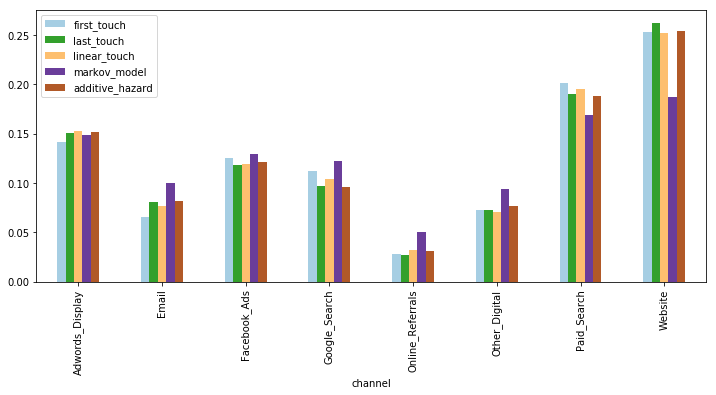

In [ ]:
df.plot(colormap='Paired', x="channel", y=["first_touch", "last_touch", "linear_touch", "markov_model", "additive_hazard"], kind="bar", figsize=(12,5))

## Criteo dataset analysis EDA

In [ ]:
%pylab inline
import pandas as pd
plt.style.use('ggplot')
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import gc

Populating the interactive namespace from numpy and matplotlib


In [ ]:
DATA_FILE='../input/criteo_attribution_dataset.tsv/criteo_attribution_dataset.tsv'
df = pd.read_csv(DATA_FILE, sep='\t')
df.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,cost,cpo,time_since_last_click,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9
0,0,20073966,22589171,0,-1,-1,0,0,-1,-1,0.000010,0.390794,-1,5824233,9312274,3490278,29196072,11409686,1973606,25162884,29196072,29196072
1,2,24607497,884761,0,-1,-1,0,0,-1,-1,0.000010,0.059600,423858,30763035,9312274,14584482,29196072,11409686,1973606,22644417,9312274,21091111
2,2,28474333,18975823,0,-1,-1,0,0,-1,-1,0.000183,0.149706,8879,138937,9312274,10769841,29196072,5824237,138937,1795451,29196072,15351056
3,3,7306395,29427842,1,1449193,3063962,0,1,0,7,0.000094,0.154785,-1,28928366,26597095,12435261,23549932,5824237,1973606,9180723,29841067,29196072
4,3,25357769,13365547,0,-1,-1,0,0,-1,-1,0.000032,0.037583,-1,138937,26597094,31616034,29196072,11409684,26597096,4480345,29196072,29196072


In [ ]:
df = df[['timestamp', 'uid', 'campaign', 'conversion', 'conversion_id', 'click', 'cat1', 'cat2', 'cat3', 'cat4',
       'cat5', 'cat6', 'cat7', 'cat8', 'cat9']]
df.head()
gc.collect()

229

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16468027 entries, 0 to 16468026
Data columns (total 16 columns):
timestamp        int64
uid              int64
campaign         int64
conversion       int64
conversion_id    int64
click            int64
cat1             int64
cat2             int64
cat3             int64
cat4             int64
cat5             int64
cat6             int64
cat7             int64
cat8             int64
cat9             int64
day              int64
dtypes: int64(16)
memory usage: 2.0 GB


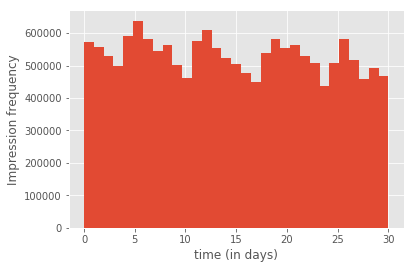

In [ ]:
ax = df.day.hist(bins=len(df.day.unique()))
ax.set_xlabel("time (in days)")
ax.set_ylabel("frequency")
plt.show()

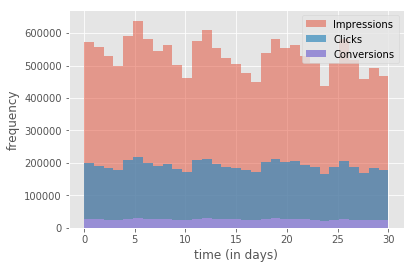

In [ ]:
ax = df.day.hist(bins=len(df.day.unique()), alpha=0.5, label='Impressions')
ax = df.loc[df['click']==1].day.hist(bins=len(df.day.unique()), alpha=0.7, label='Clicks')
ax = df.loc[df['conversion']==1].day.hist(bins=len(df.day.unique()), alpha=1, label='Conversions')
ax.legend(loc='upper right')
ax.set_xlabel("time (in days)")
ax.set_ylabel("frequency")
plt.show()

In [ ]:
df['day'] = np.floor(df.timestamp / 86400.).astype(int)

AttributeError: 'dict' object has no attribute 'get_figure'

<Figure size 432x288 with 0 Axes>

In [ ]:
# df['gap_click_sale'] = -1
# df.loc[df.conversion == 1, 'gap_click_sale'] = df.conversion_timestamp - df.timestamp

7

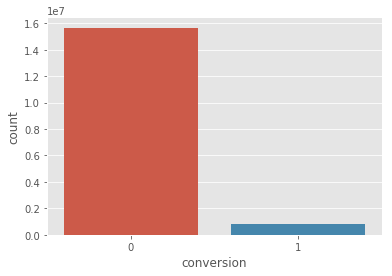

In [ ]:
df.set_index(['uid','conversion_id'], inplace=True)
df.reset_index(drop=True, inplace=True)
sns.countplot(df['conversion'])
gc.collect()

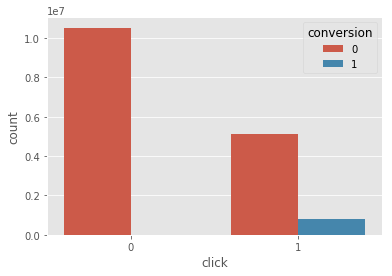

In [ ]:
sns.countplot('click', hue='conversion', data=df)

In [ ]:
df.head()

,timestamp,campaign,conversion,click,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,day
0,0,22589171,0,0,5824233,9312274,3490278,29196072,11409686,1973606,25162884,29196072,29196072,0
1,2,884761,0,0,30763035,9312274,14584482,29196072,11409686,1973606,22644417,9312274,21091111,0
2,2,18975823,0,0,138937,9312274,10769841,29196072,5824237,138937,1795451,29196072,15351056,0
3,3,29427842,1,1,28928366,26597095,12435261,23549932,5824237,1973606,9180723,29841067,29196072,0
4,3,13365547,0,0,138937,26597094,31616034,29196072,11409684,26597096,4480345,29196072,29196072,0


In [ ]:
df.columns

Index(['timestamp', 'campaign', 'conversion', 'click', 'cat1', 'cat2', 'cat3',
       'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'day'],
      dtype='object')

In [ ]:
gc.collect()

# df['timestamp']= df['timestamp'].astype('category')
df['campaign']= df['campaign'].astype('category')
df['conversion']= df['conversion'].astype('bool')
df['click']= df['click'].astype('bool')

gc.collect()

0

In [ ]:
df['cat1']= df['cat1'].astype('category')
df['cat2']= df['cat2'].astype('category')
df['cat3']= df['cat3'].astype('category')
df['cat4']= df['cat4'].astype('category')
df['cat5']= df['cat5'].astype('category')
df['cat6']= df['cat6'].astype('category')
df['cat7']= df['cat7'].astype('category')
df['cat8']= df['cat8'].astype('category')
df['cat9']= df['cat9'].astype('category')

gc.collect()


0

In [ ]:
# df.pop('day')
# df['timestamp']= df['timestamp'].astype('int')

In [ ]:
df.describe(exclude=['int'])

,campaign,conversion,click,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9
count,16468027,16468027,16468027,16468027,16468027,16468027,16468027,16468027,16468027,16468027,16468027,16468027
unique,675,2,2,9,70,1829,21,51,30,57196,11,30
top,10341182,False,False,30763035,9312274,1423188,29196072,32440044,1973606,9312274,29196072,29196072
freq,437385,15661831,10520464,7309133,8646336,335399,15292248,5085123,7289853,2264922,9816783,8770820


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


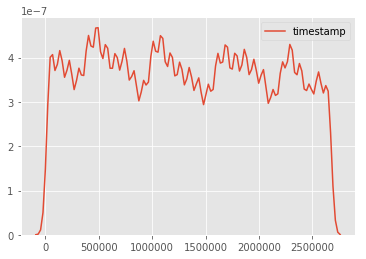

In [ ]:
sns.kdeplot(df['timestamp'])

## MTA models - LogisticRegression, AdditiveHazard, Attention RNN and Dual-attention RNN

In [ ]:
import _pickle as pkl
import os
import time
from datetime import timedelta
import sys

import numpy as np
import tensorflow as tf
from sklearn.metrics import *
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from model_config import config
from wrapped_loadCriteo import loadrnnattention
from wrapped_loadCriteo import loadLRF
from wrapped_loadCriteo import loaddualattention

## Logistic

In [ ]:
class LR_f_criteo():
    def __init__(self, path, learning_rate=0.1, epochs=10000):
        self.graph = tf.Graph()

        self._path = path
        self._save_path, self._logs_path = None, None
        self.cross_entropy, self.train_step, self.prediction = None, None, None
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.features = 5867
        self.classes = 2

        with self.graph.as_default():
            self._define_sparse_inputs()
            self._build_sparse_graph()
            self.saver = tf.train.Saver()
            self.global_initializer = tf.global_variables_initializer()
            self.local_initializer = tf.local_variables_initializer()
        self._initialize_session()

    def _define_inputs(self):
        self.X = tf.placeholder(tf.float32, [None, self.features])
        self.Y = tf.placeholder(tf.float32, [None, self.classes])

    def _define_sparse_inputs(self):
        self.X = tf.sparse_placeholder(tf.float32)
        self.Y = tf.placeholder(tf.float32, [None, self.classes])

    def _initialize_session(self, set_logs=False):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(graph=self.graph, config=config)
        self.sess.run(self.global_initializer)
        self.sess.run(self.local_initializer)

    def _build_graph(self):
        W = tf.Variable(tf.random_normal([self.features, self.classes]))
        B = tf.Variable(tf.random_normal([self.classes]))

        pY = tf.sigmoid(tf.matmul(self.X, W) + B)
        pY = tf.nn.softmax(pY)

        cost_func = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pY, labels=self.Y))
        self.cross_entropy = cost_func
        opt = tf.train.AdamOptimizer(self.learning_rate).minimize(cost_func)
        self.train_step = opt
        self.prediction = pY

    def _build_sparse_graph(self):
        W = tf.Variable(tf.random_normal([self.features, self.classes]))
        B = tf.Variable(tf.random_normal([self.classes]))
        X = tf.sparse_tensor_to_dense(self.X)

        pY = tf.sigmoid(tf.matmul(X, W) + B)
        cost_func = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pY, labels=self.Y))
        pY = tf.nn.softmax(pY)
        self.cross_entropy = cost_func
        opt = tf.train.AdamOptimizer(self.learning_rate).minimize(cost_func)
        self.train_step = opt
        self.prediction = pY
        self.W = W

    def train_one_epoch(self):
        total_time = 0
        total_loss = []
        pred = []
        label = []
        trainfile = open('train_usr.yzx.txt', 'rb')
        while True:
            train_X, train_Y = loadLRF(500, 20, 12, trainfile)
            feed_dict = {
                self.X: train_X,
                self.Y: train_Y
            }
            fetches = [self.train_step, self.cross_entropy, self.prediction]
            result = self.sess.run(fetches, feed_dict=feed_dict)
            _, loss, prediction = result
            total_loss.append(loss)
            pred += prediction.tolist()
            label += train_Y
            if len(train_Y) < 500:
                break
        pred = np.array(pred)
        auc = roc_auc_score(np.argmax(label, 1), pred[:, 1])
        print("Training AUC = " + "{:.4f}".format(auc))
        mean_loss = np.mean(total_loss)
        print("Training Loss = " + "{:.4f}".format(mean_loss))
        _pY = np.argmax(pred, 1)
        Y = np.argmax(label, 1)
        precision = precision_score(Y, _pY)
        recall = recall_score(Y, _pY)
        F1 = f1_score(Y, _pY)
        accuracy = accuracy_score(Y, _pY)
        return mean_loss, auc, accuracy, precision, recall, F1

    def train_all_epochs(self):
        total_start_time = time.time()
        losses = []
        for epoch in range(self.epochs):
            print("Training...")
            result = self.train_one_epoch()
            loss = result[0]
            losses.append(loss)
            self.test(epoch)
            
            if epoch > 3:
                if losses[-1] >= losses[-2] and losses[-2] >= losses[-3]:
                    break

    def test(self, epoch):
        total_loss = []
        pred = []
        label = []
        file = open('test_usr.yzx.txt', 'rb')
        while True:
            train_X, train_Y = loadLRF(500, 20, 12, file)
            feed_dict = {
                self.X: train_X,
                self.Y: train_Y
            }
            fetches = [self.train_step, self.cross_entropy, self.prediction]
            result = self.sess.run(fetches, feed_dict=feed_dict)
            _, loss, prediction = result
            total_loss.append(loss)
            pred += prediction.tolist()
            label += train_Y
            if len(train_Y) < 500:
                break
        pred = np.array(pred)
        auc = roc_auc_score(np.argmax(label, 1), pred[:, 1])
        loglikelihood = -log_loss(np.argmax(label, 1), pred[:, 1])
        print("Test AUC = " + "{:.4f}".format(auc))
        mean_loss = np.mean(total_loss)
        print("Test Loss = " + "{:.4f}".format(mean_loss))
        _pY = np.argmax(pred, 1)
        Y = np.argmax(label, 1)
        precision = precision_score(Y, _pY)
        recall = recall_score(Y, _pY)
        F1 = f1_score(Y, _pY)
        accuracy = accuracy_score(Y, _pY)
        result = mean_loss, auc, loglikelihood, accuracy, precision, recall, F1

    def attr(self):
        file = open('test_usr.yzx.txt', 'rb')
        channelfile = open('i2c_converted.pkl', 'rb')
        channel_set = pkl.load(channelfile)
        outfile = open('lr_f.txt', 'w')
        train_X, train_Y = loadLRF(1, 20, 12, file)
        feed_dict = {
            self.X: train_X,
            self.Y: train_Y
        }
        W = self.sess.run(self.W, feed_dict)
        for key in channel_set:
            outfile.write(channel_set[key] + '\t' + str(W[int(key)][1]) + '\n')

In [ ]:
if __name__ == '__main__':
    learning_rate = 0.01
    epochs = 5
    model = LR_f_criteo("../Model/LR", learning_rate=learning_rate, epochs=epochs)
    model.train_all_epochs()
#     model.test(0)
    model.attr()

Training...
Training AUC = 0.7139
Training Loss = 0.5866
Test AUC = 0.9097
Test Loss = 0.4341
Training...
Training AUC = 0.9434
Training Loss = 0.4146
Test AUC = 0.9580
Test Loss = 0.4014
Training...
Training AUC = 0.9638
Training Loss = 0.3959
Test AUC = 0.9688
Test Loss = 0.3895
Training...
Training AUC = 0.9706
Training Loss = 0.3871
Test AUC = 0.9732
Test Loss = 0.3831
Training...
Training AUC = 0.9740
Training Loss = 0.3820
Test AUC = 0.9755
Test Loss = 0.3792


## Survival Additive Hazard

In [ ]:
import loadCriteo

def optmize(data, num_of_channel, beta, omega):
    # Preparation

    for item in data:
        item['p'] = np.zeros(len(item['action']))

    # update_P
    for item in data:
        X_u = item['isconversion']
        if (X_u == 0):
            continue
        T_u = item['conversionTime']
        l = len(item['action'])
        sum_p = 0.
        for i in range(l):
            a_i = item['action'][i][0]
            t_i = item['action'][i][1]
            item['p'][i] = beta[a_i] * omega[a_i] * np.exp(-omega[a_i] * (T_u - t_i))
            sum_p += item['p'][i]
        for i in range(l):
            item['p'][i] = item['p'][i] / sum_p

    # update_Beta
    fz = np.zeros(num_of_channel)
    fmb = np.zeros(num_of_channel)
    for item in data:
        X_u = item['isconversion']
        T_u = item['conversionTime']
        l = len(item['action'])
        for i in range(l):
            a_i = item['action'][i][0]
            t_i = item['action'][i][1]
            fmb[a_i] += 1 - np.exp(-omega[a_i] * (T_u - t_i))
            if (X_u == 1):
                fz[a_i] += item['p'][i]

    # update_ogema
    fz = np.zeros(num_of_channel)
    fm = np.zeros(num_of_channel)
    for item in data:
        X_u = item['isconversion']
        T_u = item['conversionTime']
        l = len(item['action'])
        for i in range(l):
            a_i = item['action'][i][0]
            t_i = item['action'][i][1]
            fm[a_i] += item['p'][i] * (T_u - t_i) + beta[a_i] * (T_u - t_i) * np.exp(-omega[a_i] * (T_u - t_i))
            if (X_u == 1):
                fz[a_i] += item['p'][i]

    for k in range(num_of_channel):
        if (fm[k] > 0.):
            if fm[k] < 1e-10:
                fm[k] = 1e-5
            omega[k] = fz[k] / fm[k]

    for k in range(num_of_channel):
        if (fmb[k] > 0.):
            beta[k] = fz[k] / fmb[k]
    return beta, omega


def attr(beta, omega, num_of_channel, data):
    for item in data:
        item['p'] = np.zeros(len(item['action']), dtype=np.float64)

    for item in data:
        X_u = item['isconversion']
        if (X_u == 0):
            continue
        T_u = item['conversionTime']
        l = len(item['action'])
        sum_p = 0.
        for i in range(l):
            a_i = item['action'][i][0]
            t_i = item['action'][i][1]
            item['p'][i] = beta[a_i] * omega[a_i] * np.exp(-omega[a_i] * (T_u - t_i))
            sum_p += item['p'][i]
        for i in range(l):
            item['p'][i] = item['p'][i] / sum_p
    global ChannelList
    ChannelSet = pkl.load(open('i2c_converted.pkl', 'rb'))
    channel_value = {}
    channel_time = {}
    for item in data:
        X_u = item['isconversion']
        if (X_u == 0):
            continue
        l = len(item['action'])
        for i in range(l):
            a_i = item['action'][i][0]
            channel = ChannelList[a_i]
            if channel in channel_value:
                channel_value[channel] += item['p'][i]
                channel_time[channel] += 1
            else:
                channel_value[channel] = item['p'][i]
                channel_time[channel] = 1
    outfile = open('survival.txt', 'w')
    for channel in channel_value:
        outfile.write(ChannelSet[str(channel)] + '\t' + str(channel_value[channel] / channel_time[channel]) + '\n')


def vertical_attr(beta, omega, num_of_channel, data, lenth):
    for item in data:
        item['p'] = np.zeros(len(item['action']), dtype=np.float64)

    for item in data:
        X_u = item['isconversion']
        if (X_u == 0):
            continue
        T_u = item['conversionTime']
        l = len(item['action'])
        sum_p = 0.
        for i in range(l):
            a_i = item['action'][i][0]
            t_i = item['action'][i][1]
            item['p'][i] = beta[a_i] * omega[a_i] * np.exp(-omega[a_i] * (T_u - t_i))
            sum_p += item['p'][i]
        for i in range(l):
            item['p'][i] = item['p'][i] / sum_p
    v = [0.] * lenth
    for item in data:
        X_u = item['isconversion']
        if (X_u == 0):
            continue
        l = len(item['action'])
        if l != lenth:
            continue
        for i in range(l):
            v[i] += item['p'][i]
    print(v)


def test(beta, omega, num_of_channel, test_data):
    y = []
    pred = []
    for item in test_data:
        y.append(item['isconversion'])
        ans = 1.
        T_u = item['conversionTime']
        Diff_Set = {}
        for tmp in item['action']:
            a_i = tmp[0]
            if a_i not in Diff_Set:
                Diff_Set[a_i] = 1
            t_i = tmp[1]
            # print T_u - t_i
            pred_now = np.exp(-beta[a_i] * (1 - np.exp(-omega[a_i] * (T_u - t_i + 0.1))))
            ans *= pred_now
        pred.append((1. - ans) * (0.95 ** len(Diff_Set)))

    auc = roc_auc_score(y, pred)
    loglikelihood = -log_loss(y, pred)
    print("Testing Auc= " + "{:.6f}".format(auc))
    print("Testing loglikelihood " + "{:.6f}".format(loglikelihood))
    return auc


num_of_epoches = 20

train_path = 'train_usr.yzx.txt'
test_path = 'test_usr.yzx.txt'
traindata_size = loadCriteo.count(train_path)
testdata_size = loadCriteo.count(test_path)

ChannelSet = {}
ChannelList = []


def loadCriteoData(datasize, fin):
    total_data = []
    for i in range(datasize):
        tmpseq = {}
        try:
            (tmp_seq_len, tmp_label) = [int(_) for _ in fin.readline().split()]
            tmpseq['isconversion'] = tmp_label
            tmp_action = []
            for _ in range(tmp_seq_len):
                tmpline = fin.readline().split()
                tmp_campaign, tmp_time = int(tmpline[2]), float(tmpline[0]) * 31.
                global ChannelSet, ChannelList
                if tmp_campaign not in ChannelSet:
                    ChannelSet[tmp_campaign] = len(ChannelList)
                    ChannelList.append(tmp_campaign)
                tmp_action.append((ChannelSet[tmp_campaign], tmp_time))
                if _ == tmp_seq_len - 1:
                    tmpseq['conversionTime'] = tmp_time
            tmpseq['action'] = tmp_action
        except:
            continue
        total_data.append(tmpseq)
    print(len(total_data))
    return total_data

64582
32306
load dataset finished, 1.0548315048217773 seconds took
Test on Epoch 0
Testing Auc= 0.619407
Testing loglikelihood -0.748695
Test on Epoch 1
Testing Auc= 0.643299
Testing loglikelihood -0.659513
Test on Epoch 2
Testing Auc= 0.657835
Testing loglikelihood -0.620221
Test on Epoch 3
Testing Auc= 0.662366
Testing loglikelihood -0.599246
Test on Epoch 4
Testing Auc= 0.667866
Testing loglikelihood -0.590739
Test on Epoch 5
Testing Auc= 0.669182
Testing loglikelihood -0.584512
Test on Epoch 6
Testing Auc= 0.671465
Testing loglikelihood -0.580984
Test on Epoch 7
Testing Auc= 0.671270
Testing loglikelihood -0.578722
Test on Epoch 8
Testing Auc= 0.672172
Testing loglikelihood -0.576397
Test on Epoch 9
Testing Auc= 0.671579
Testing loglikelihood -0.573746
Test on Epoch 10
Testing Auc= 0.672194
Testing loglikelihood -0.571990
Test on Epoch 11
Testing Auc= 0.672120
Testing loglikelihood -0.571076
Test on Epoch 12
Testing Auc= 0.672616
Testing loglikelihood -0.570305
Test on Epoch 13
Tes

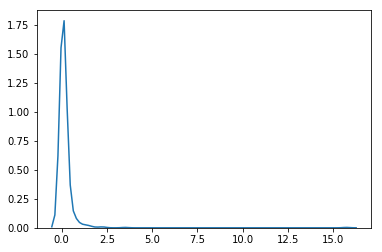

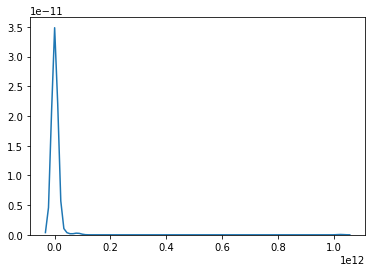

In [ ]:
def main():
    start_time = time.time()
    with open(train_path) as f_train:
        train_data = loadCriteoData(traindata_size, f_train)
    with open(test_path) as f_test:
        test_data = loadCriteoData(testdata_size, f_test)
    finish_time = time.time()
    print("load dataset finished, {} seconds took".format(finish_time - start_time))
    num_of_channel = len(ChannelList)
    beta = np.random.uniform(0, 1, num_of_channel)
    omega = np.random.uniform(0, 1, num_of_channel)
    auc = []
    beta_list = []
    omega_list = []
    for epoch in range(num_of_epoches):
        beta, omega = optmize(train_data, num_of_channel, beta, omega)
        print('Test on Epoch %d' % epoch)
        auc.append(test(beta, omega, num_of_channel, test_data))
        beta_list.append(beta)
        omega_list.append(omega)
        if epoch > 10 and auc[-1] < auc[-2] < auc[-3]:
            break
    sns.kdeplot(beta_list[-1])
    plt.show()
    sns.kdeplot(omega_list[-1])
    plt.show()
    attr(beta_list[-1],omega_list[-1],671,train_data)
      
if __name__ == "__main__":
    main()

## ARNN

In [ ]:
class RnnWithattention(object):
    def __init__(self, path, train_dataset, test_dataset, config):
        self.graph = tf.Graph()

        self._path = path
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self._save_path, self._logs_path = None, None
        self.config = config
        self.batches_step = 0
        self.cross_entropy, self.train_step, self.prediction = None, None, None
        self.data_shape = config.data_shape
        self.label_shape = config.label_shape
        self.n_classes = config.n_classes
        self.attention = None
        with self.graph.as_default():
            self._define_inputs()
            self._build_graph()
            self.initializer = tf.global_variables_initializer()
            self.saver = tf.train.Saver()
        self._initialize_session()

    def _define_inputs(self):
        shape = [None]
        shape.extend(self.data_shape)
        label_shape = [None]
       
        self.input = tf.placeholder(tf.float32, shape=[None, self.config.seq_max_len, 12], name='input')
        self.labels = tf.placeholder(tf.float32, shape=label_shape, name='labels')
        self.learning_rate = tf.placeholder(tf.float32, shape=[], name='learning_rate')
        self.seqlen = tf.placeholder(tf.int32, shape=[None], name='seqlen')
        self.is_training = tf.placeholder(tf.bool, shape=[], name='is_training')
        self.keep_prob = tf.placeholder(tf.float32, shape=[], name='keep_prob')

    def _initialize_session(self, set_logs=False):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(graph=self.graph, config=config)
        self.sess.run(self.initializer)

    def _build_graph(self):
        x = self.input
        batchsize = tf.shape(x)[0]
        embedding_matrix = tf.Variable(
            tf.random_normal([self.config.max_features, self.config.embedding_output], stddev=0.1))
        x1, x2 = tf.split(x, [2, 10], 2)
        x2 = tf.to_int32(x2)
        x2 = tf.nn.embedding_lookup(embedding_matrix, x2)
        x2 = tf.reshape(x2, [-1, self.config.seq_max_len, 10 * self.config.embedding_output])
        x = tf.concat((x1, x2), axis=2)
        weights = {
            'out': tf.Variable(tf.random_normal([self.config.n_hidden])),
            'attention_h': tf.Variable(tf.random_normal([self.config.n_hidden, self.config.n_hidden])),
            'attention_x': tf.Variable(tf.random_normal([self.config.n_input, self.config.n_hidden])),
            'v_a': tf.Variable(tf.random_normal([self.config.n_hidden]))
        }
        biases = {
            'out': tf.Variable(tf.random_normal(shape=[self.config.batch_size], dtype=tf.float32))
        }

        index = tf.range(0, self.config.batch_size) * self.config.seq_max_len + (self.seqlen - 1)
        x_last = tf.gather(tf.reshape(x, [-1, self.config.n_input]), index)
        x = tf.transpose(x, [1, 0, 2])
        x = tf.reshape(x, [-1, self.config.n_input])
        x = tf.split(axis=0, num_or_size_splits=self.config.seq_max_len, value=x)

        lstm_cell = tf.contrib.rnn.BasicLSTMCell(self.config.n_hidden)
        lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, input_keep_prob=self.keep_prob,
                                                  output_keep_prob=self.keep_prob)
        outputs, states = tf.contrib.rnn.static_rnn(lstm_cell, x, dtype=tf.float32, sequence_length=self.seqlen)

        # attention
        e = []
        Ux = tf.matmul(x_last, weights['attention_x'])
        for output in outputs:
            e_ = tf.reduce_sum(tf.multiply(tf.tanh(tf.matmul(output, weights['attention_h']) + Ux), weights['v_a']),
                               reduction_indices=1)
            e.append(e_)
        e = tf.stack(e)
        a = tf.nn.softmax(e, dim=0)
        a = tf.split(a, self.config.seq_max_len, 0)
        c = tf.zeros([self.config.batch_size, self.config.n_hidden])
        for i in range(self.config.seq_max_len):
            c = c + tf.multiply(outputs[i], tf.transpose(a[i]))
        cvr = tf.reduce_sum(tf.multiply(c, weights['out']), axis=1) + biases['out']
        cvr = tf.nn.dropout(cvr, keep_prob=self.keep_prob)
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=self.labels, logits=cvr))
        cvr = tf.nn.sigmoid(cvr)
        for v in tf.trainable_variables():
            loss += self.config.miu * tf.nn.l2_loss(v)
        optimizer = tf.train.AdamOptimizer(learning_rate=self.config.learning_rate)
        gvs, v = zip(*optimizer.compute_gradients(loss))
        gvs, _ = tf.clip_by_global_norm(gvs, 5.0)
        gvs = zip(gvs, v)

        self.cross_entropy = loss
        self.train_step = optimizer.apply_gradients(gvs)
        self.prediction = cvr
        self.attention = a

    def train_one_epoch(self, batch_size, learning_rate):
        total_loss = []
        cvr_pred = []
        cvr_label = []
        infile = open(self.train_dataset, 'rb')
        while True:
            batch = loadrnnattention(batch_size, self.config.seq_max_len, self.config.feature_number, infile)
            train_data, train_compaign_data, train_label, train_seqlen = batch
            if len(train_label) != batch_size:
                break
            feed_dict = {
                self.input: train_data,
                self.labels: train_label,
                self.seqlen: train_seqlen,
                self.learning_rate: learning_rate,
                self.is_training: True,
                self.keep_prob: 0.5
            }

            result = self.sess.run([self.train_step, self.cross_entropy, self.prediction], feed_dict=feed_dict)
            _, loss, cvr = result
            total_loss.append(loss)
            cvr_pred += cvr.tolist()
            cvr_label += train_label
        auc_cov = roc_auc_score(cvr_label, cvr_pred)
        print("conversion_AUC = " + "{:.4f}".format(auc_cov))
        mean_loss = np.mean(total_loss)
        print("Loss = " + "{:.4f}".format(mean_loss))
        return mean_loss, auc_cov

    def train_all_epochs(self, start_epoch=1):
        n_epoches = self.config.n_epochs
        learning_rate = self.config.learning_rate
        batch_size = self.config.batch_size

        for epoch in range(start_epoch, n_epoches + 1):
            print('\n', '-' * 30, 'Train epoch: %d' % epoch, '-' * 30, '\n')
            start_time = time.time()

            print("Training...")
            result = self.train_one_epoch(batch_size, learning_rate)

    def train_until_cov(self):
        learning_rate = self.config.learning_rate
        batch_size = self.config.batch_size

        epoch = 1
        losses = []
        n_epochs = self.config.n_epochs

        while True:
            print('-' * 30, 'Train epoch: %d' % epoch, '-' * 30)
           
            print("Training...")
            # if epoch > 50 or (epoch > 3 and clk_losses[-1] < clk_losses[-2] < clk_losses[-3]):
            #     fetch = [self.train_step, self.clk_loss, self.cov_loss, self.cross_entropy, self.click_prediction,
            #              self.conversion_prediction]
            result = self.train_one_epoch(batch_size, learning_rate)
            
            self.test(epoch)
            loss = result[0]
            losses.append(loss)
            if epoch > 10 and losses[-1] > losses[-2] > losses[-3]:
                break
            epoch += 1
            
    def test(self, epoch):
        batch_size = self.config.batch_size
        total_loss = []
        cvr_pred = []
        cvr_label = []
        infile = open(self.test_dataset, 'rb')
        while True:
            batch = loadrnnattention(batch_size, self.config.seq_max_len, self.config.feature_number, infile)
            test_data, test_compaign_data, test_label, test_seqlen = batch
            if len(test_label) != batch_size:
                break
            feed_dict = {
                self.input: test_data,
                self.labels: test_label,
                self.seqlen: test_seqlen,
                self.is_training: False,
                self.keep_prob: 1
            }
            fetches = [self.cross_entropy, self.prediction]
            result = self.sess.run(fetches, feed_dict=feed_dict)
            loss, cvr = result
            total_loss.append(loss)
            cvr_pred += cvr.tolist()
            cvr_label += test_label
        auc_cov = roc_auc_score(cvr_label, cvr_pred)
        log = log_loss(cvr_label, cvr_pred)
        print("loglikelihood = " + "{:.4f}".format(log))
        print("conversion_AUC = " + "{:.4f}".format(auc_cov))
        mean_loss = np.mean(total_loss)
        print("Loss = " + "{:.4f}".format(mean_loss))
        return auc_cov

    def attr(self):
        filec = open('i2c_converted.pkl', 'rb')
        Channel_Set = pkl.load(filec)
        Channel_value = {}
        Channel_time = {}
        infile = open(self.test_dataset, 'rb')
        outfile = open('rnn_withattention.txt', 'w')
        while True:
            batch = loadrnnattention(self.config.batch_size, self.config.seq_max_len, self.config.feature_number,
                                     infile)
            test_data, test_compaign_data, test_label, test_seqlen = batch
            if len(test_label) != self.config.batch_size:
                break
            feed_dict = {
                self.input: test_data,
                self.labels: test_label,
                self.seqlen: test_seqlen,
                self.is_training: False,
                self.keep_prob: 1
            }
            fetches = self.attention
            attention = self.sess.run(fetches, feed_dict=feed_dict)
            for i in range(self.config.batch_size):
                if test_label[i] != 0:
                    for j in range(test_seqlen[i]):
                        # if click_label[i][j] == 1:
                        index = Channel_Set[str(test_data[i][j][2])]
                        v = attention[j][0][i]
                        if index in Channel_value:
                            Channel_value[index] += v
                            Channel_time[index] += 1
                        else:
                            Channel_value[index] = v
                            Channel_time[index] = 1

        for key in Channel_value:
            outfile.write(key + '\t' + str(Channel_value[key] / Channel_time[key]) + '\n')

    def vertical_attr(self, lenth):
        batch_size = self.config.batch_size
        value = [0.] * lenth
        infile = open(self.test_dataset, 'rb')
        while True:
            batch = loadrnnattention(self.config.batch_size, self.config.seq_max_len, self.config.feature_number,
                                     infile)
            test_data, test_compaign_data, test_label, test_seqlen = batch
            if len(test_label) != self.config.batch_size:
                break
            feed_dict = {
                self.input: test_data,
                self.labels: test_label,
                self.seqlen: test_seqlen,
                self.is_training: False,
                self.keep_prob: 1
            }
            fetches = self.attention
            attention = self.sess.run(fetches, feed_dict=feed_dict)
            for i in range(batch_size):
                if test_seqlen[i] == lenth and test_label[i] == 1:
                    for j in range(test_seqlen[i]):
                        # if click_label[i][j] == 1:
                        v = attention[j][0][i]
                        value[j] += v

        print(value)

In [ ]:
if __name__ == '__main__':
    traindata = 'train_usr.yzx.txt'
    testdata = 'test_usr.yzx.txt'
    learning_rate = 0.005
    batch_size = 512
    mu = 1e-6

    C = config(max_features=5897, learning_rate=learning_rate, batch_size=batch_size, feature_number=12,
               seq_max_len=20, n_input=2,
               embedding_output=256, n_hidden=512, n_classes=2, n_epochs=10, isseq=True, miu=mu)
    path = '../Model/ARNN'
    model = RnnWithattention(path, traindata, testdata, C)
    model.train_until_cov()
    model.test(0)
    model.attr()

------------------------------ Train epoch: 1 ------------------------------
Training...
conversion_AUC = 0.4972
Loss = 1.6529
loglikelihood = 0.7310
conversion_AUC = 0.5039
Loss = 1.4586
------------------------------ Train epoch: 2 ------------------------------
Training...
conversion_AUC = 0.5005
Loss = 1.4551
loglikelihood = 0.6696
conversion_AUC = 0.5036
Loss = 1.3426
------------------------------ Train epoch: 3 ------------------------------
Training...
conversion_AUC = 0.5024
Loss = 1.3476
loglikelihood = 0.6244
conversion_AUC = 0.5034
Loss = 1.2531
------------------------------ Train epoch: 4 ------------------------------
Training...
conversion_AUC = 0.5011
Loss = 1.2695
loglikelihood = 0.5950
conversion_AUC = 0.5026
Loss = 1.1864
------------------------------ Train epoch: 5 ------------------------------
Training...
conversion_AUC = 0.5025
Loss = 1.2116
loglikelihood = 0.5759
conversion_AUC = 0.5020
Loss = 1.1331
------------------------------ Train epoch: 6 --------------

## DARNN

In [ ]:
class DualAttention(object):
    def __init__(self, path, train_dataset, test_dataset, config):
        self.graph = tf.Graph()

        self._path = path
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self._save_path, self._logs_path = None, None
        self.config = config
        self.batches_step = 0
        self.cross_entropy, self.train_step, self.prediction = None, None, None
        self.data_shape = config.data_shape
        self.label_shape = config.label_shape
        self.n_classes = config.n_classes
        self.attention = None
        with self.graph.as_default():
            self._define_inputs()
            self._build_graph()
            self.initializer = tf.global_variables_initializer()
            self.saver = tf.train.Saver()
        self._initialize_session()

    @property
    def save_path(self):
        if self._save_path is None:
            save_path = '%s/checkpoint' % self._path
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            save_path = os.path.join(save_path, 'model.ckpt')
            self._save_path = save_path
        return self._save_path

    @property
    def logs_path(self):
        if self._logs_path is None:
            logs_path = '%s/logs' % self._path
            if not os.path.exists(logs_path):
                os.makedirs(logs_path)
            self._logs_path = logs_path
        return self._logs_path

    def _define_inputs(self):
        shape = [None]
        shape.extend(self.data_shape)
        label_shape = [None]
        self.input = tf.placeholder(
            tf.float32,
            shape=[None, self.config.seq_max_len, 12]
        )
        self.click_label = tf.placeholder(
            tf.float32,
            shape=[None, self.config.seq_max_len, self.config.n_classes]
        )
        self.labels = tf.placeholder(
            tf.float32,
            shape=label_shape,
            name='labels'
        )
        self.learning_rate = tf.placeholder(
            tf.float32,
            shape=[],
            name='learning_rate'
        )
        self.seqlen = tf.placeholder(
            tf.int32,
            shape=[None],
            name='seqlen'
        )
        self.is_training = tf.placeholder(tf.bool, shape=[], name='is_training')
        self.keep_prob = tf.placeholder(tf.float32, shape=[], name='keep_prob')

    def _initialize_session(self, set_logs=True):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(graph=self.graph, config=config)

        self.sess.run(self.initializer)
        if set_logs:
            logswriter = tf.summary.FileWriter
            self.summary_writer = logswriter(self.logs_path, graph=self.graph)

    def _build_graph(self):
        x = self.input
        batchsize = tf.shape(x)[0]
        embedding_matrix = tf.Variable(
            tf.random_normal([self.config.max_features, self.config.embedding_output], stddev=0.1))
        x1, x2 = tf.split(x, [2, 10], 2)
        x2 = tf.to_int32(x2)
        x2 = tf.nn.embedding_lookup(embedding_matrix, x2)
        x2 = tf.reshape(x2, [-1, self.config.seq_max_len, 10 * self.config.embedding_output])
        x = tf.concat((x1, x2), axis=2)
        # Define Variables
        W = tf.Variable(tf.random_normal([self.config.n_classes, self.config.n_hidden], stddev=0.1), name='W')
        U = tf.Variable(tf.random_normal([self.config.n_hidden, self.config.n_hidden], stddev=0.1), name='U')
        C = tf.Variable(tf.random_normal([self.config.n_hidden, self.config.n_hidden], stddev=0.1), name='C')
        U_a = tf.Variable(tf.random_normal([self.config.n_hidden, self.config.n_hidden], stddev=0.1), name='U_a')
        # W_a = tf.Variable(tf.random_normal([self.config.n_hidden, self.config.n_hidden], stddev=0.1), name='W_a')
        v_a = tf.Variable(tf.random_normal([self.config.n_hidden], stddev=0.1), name='v_a')
        W_z = tf.Variable(tf.random_normal([self.config.n_classes, self.config.n_hidden], stddev=0.1), name='W_z')
        U_z = tf.Variable(tf.random_normal([self.config.n_hidden, self.config.n_hidden], stddev=0.1), name='U_z')
        C_z = tf.Variable(tf.random_normal([self.config.n_hidden, self.config.n_hidden], stddev=0.1), name='C_z')
        W_r = tf.Variable(tf.random_normal([self.config.n_classes, self.config.n_hidden], stddev=0.1), name='W_r')
        U_r = tf.Variable(tf.random_normal([self.config.n_hidden, self.config.n_hidden], stddev=0.1), name='U_r')
        C_r = tf.Variable(tf.random_normal([self.config.n_hidden, self.config.n_hidden], stddev=0.1), name='C_r')
        W_s = tf.Variable(tf.random_normal([self.config.n_hidden, self.config.n_hidden], stddev=0.1), name='W_s')
        W_o = tf.Variable(tf.random_normal([self.config.n_hidden, self.config.n_classes], stddev=0.1), name='W_o')
        b_o = tf.Variable(tf.random_normal([self.config.n_classes], stddev=0.1), name='b_o')
        W_h = tf.Variable(tf.random_normal([self.config.n_hidden, self.config.n_hidden], stddev=0.1), name='W_h')
        U_s = tf.Variable(tf.random_normal([self.config.n_hidden, self.config.n_hidden], stddev=0.1), name='U_s')
        W_C = tf.Variable(tf.random_normal([self.config.n_hidden, self.config.n_hidden], stddev=0.1), name='W_C')
        W_x1 = tf.Variable(tf.random_normal([self.config.n_input, self.config.n_hidden], stddev=0.1), name='W_x1')
        W_x2 = tf.Variable(tf.random_normal([self.config.n_input, self.config.n_hidden], stddev=0.1), name='W_x2')
        W_x3 = tf.Variable(tf.random_normal([self.config.n_input, self.config.n_hidden], stddev=0.1), name='W_x3')
        v_a2 = tf.Variable(tf.random_normal([self.config.n_hidden], stddev=0.1), name='v_a2')
        v_a3 = tf.Variable(tf.random_normal([self.config.n_hidden], stddev=0.1), name='v_a3')
        W_c = tf.Variable(tf.random_normal([self.config.n_hidden], stddev=0.1), name='W_c')
        b_c = tf.Variable(tf.random_normal([self.config.batch_size]))

        index = tf.range(0, batchsize) * self.config.seq_max_len + (self.seqlen - 1)
        x_last = tf.gather(params=tf.reshape(x, [-1, self.config.n_input]), indices=index)
        x = tf.transpose(x, [1, 0, 2])
        # x = tf.reshape(x,[-1, self.config.n_input])
        # x = tf.split(axis=0, num_or_size_splits=self.config.seq_max_len, value=x)
        y = tf.transpose(self.click_label, [1, 0, 2])
        y = tf.reshape(y, [-1, self.config.n_classes])
        y = tf.split(value=y, num_or_size_splits=self.config.seq_max_len, axis=0)
        # encoder
        gru_cell = tf.contrib.rnn.GRUCell(self.config.n_hidden)
        gru_cell = tf.nn.rnn_cell.DropoutWrapper(gru_cell, input_keep_prob=self.keep_prob,
                                                 output_keep_prob=self.keep_prob)
        states_h, last_h = tf.nn.dynamic_rnn(gru_cell, x, self.seqlen, dtype=tf.float32, time_major=True)
        states_h = tf.reshape(states_h, [-1, self.config.n_hidden])
        states_h = tf.split(states_h, self.config.seq_max_len, 0)

        Uhs = []
        for state_h in states_h:
            Uh = tf.matmul(state_h, U_a)
            Uhs.append(Uh)

        # decoder
        state_s = tf.tanh(tf.matmul(states_h[-1], W_s))
        # s0 =  tanh(Ws * h_last)
        states_s = [state_s]
        outputs = []
        output = tf.zeros(shape=[batchsize, self.config.n_classes])
        for i in range(self.config.seq_max_len):
            # e = []
            # for Uh in Uhs:
            # 	e_ = tf.reduce_sum(tf.multiply(tf.tanh(tf.matmul(states_s[i], W_a) + Uh), v_a), reduction_indices=1)
            # 	e.append(e_)
            # e = tf.stack(e)
            # # (seq_max_len, batch_size)
            # a1 = tf.nn.softmax(e, dim=0)
            # a1 = tf.split(a1, self.config.seq_max_len, 0)
            # c = tf.zeros([batchsize, self.config.n_hidden])
            # for j in range(self.config.seq_max_len):
            # 	c = c + tf.multiply(states_h[j], tf.transpose(a1[j]))
            c = states_h[-1]
            if self.is_training == True:
                last_output = y[i]
            else:
                last_output = tf.nn.softmax(output)
            r = tf.sigmoid(tf.matmul(last_output, W_r) + tf.matmul(states_s[i], U_r) + tf.matmul(c, C_r))
            z = tf.sigmoid(tf.matmul(last_output, W_z) + tf.matmul(states_s[i], U_z) + tf.matmul(c, C_z))
            s_hat = tf.tanh(tf.matmul(last_output, W) + tf.matmul(tf.multiply(r, states_s[i]), U) + tf.matmul(c, C))
            state_s = tf.multiply(tf.subtract(1.0, z), states_s[i]) + tf.multiply(z, s_hat)
            states_s.append(state_s)
            state_s = tf.nn.dropout(state_s, self.keep_prob)
            output = tf.matmul(state_s, W_o) + b_o
            outputs.append(output)

        e2 = []
        e3 = []
        Ux = tf.matmul(x_last, W_x1)
        Ux2 = tf.matmul(x_last, W_x2)
        for i in range(self.config.seq_max_len):
            e2_ = tf.reduce_sum(tf.multiply(tf.tanh(tf.matmul(states_h[i], W_h) + Ux), v_a2), reduction_indices=1)
            e2.append(e2_)
            e3_ = tf.reduce_sum(tf.multiply(tf.tanh(tf.matmul(states_s[i], U_s) + Ux2), v_a3), reduction_indices=1)
            e3.append(e3_)
        e2 = tf.stack(e2)
        e3 = tf.stack(e3)
        a2 = tf.nn.softmax(e2, dim=0)
        a3 = tf.nn.softmax(e3, dim=0)
        a2 = tf.split(a2, self.config.seq_max_len, 0)
        a3 = tf.split(a3, self.config.seq_max_len, 0)
        c2 = tf.zeros([batchsize, self.config.n_hidden])
        c3 = tf.zeros([batchsize, self.config.n_hidden])
        for i in range(self.config.seq_max_len):
            c2 = c2 + tf.multiply(states_h[i], tf.transpose(a2[i]))
            c3 = c3 + tf.multiply(states_s[i], tf.transpose(a3[i]))
        e4 = []
        Ux3 = tf.matmul(x_last, W_x3)
        e4.append(tf.reduce_sum(tf.multiply(tf.tanh(tf.matmul(c2, W_C) + Ux3), v_a), reduction_indices=1))
        e4.append(tf.reduce_sum(tf.multiply(tf.tanh(tf.matmul(c3, W_C) + Ux3), v_a), reduction_indices=1))
        e4 = tf.stack(e4)
        a4 = tf.split(tf.nn.softmax(e4, dim=0), 2, 0)
        C = tf.multiply(c2, tf.transpose(a4[0])) + tf.multiply(c3, tf.transpose(a4[1]))
        # self.attention = C
        cvr = tf.reduce_sum(tf.multiply(C, W_c), axis=1) + b_c
        cvr = tf.nn.dropout(cvr, keep_prob=self.keep_prob)
        conversion_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=self.labels, logits=cvr))
        cvr = tf.nn.sigmoid(cvr)
        mask = tf.sequence_mask(self.seqlen, self.config.seq_max_len)
        outputs = tf.stack(outputs)
        outputs = tf.transpose(outputs, [1, 0, 2])
        # (batchsize, max_seq_len, n_classes)
        loss_click = tf.nn.softmax_cross_entropy_with_logits(labels=self.click_label, logits=outputs)
        loss_click = tf.boolean_mask(loss_click, mask)
        loss_click = tf.reduce_mean(loss_click)
        click_pred = tf.nn.softmax(outputs)
        loss = loss_click + conversion_loss
        for v in tf.trainable_variables():
            loss += self.config.miu * tf.nn.l2_loss(v)
            loss_click += self.config.miu * tf.nn.l2_loss(v)
            conversion_loss += self.config.miu * tf.nn.l2_loss(v)

        global_step = tf.Variable(0, trainable=False)
        start_learningrate = self.config.learning_rate
        cov_learning_rate = tf.train.exponential_decay(start_learningrate, global_step, 50000, 0.96)
        clk_optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
        optimizer = tf.train.AdamOptimizer(learning_rate=cov_learning_rate)
        gvs_clk, v_clk = zip(*clk_optimizer.compute_gradients(loss_click))
        gvs_clk, _ = tf.clip_by_global_norm(gvs_clk, 5.0)
        gvs_clk = zip(gvs_clk, v_clk)
        gvs_cov, v_cov = zip(*optimizer.compute_gradients(conversion_loss))
        gvs_cov, _ = tf.clip_by_global_norm(gvs_cov, 5.0)
        gvs_cov = zip(gvs_cov, v_cov)
        gvs, v = zip(*optimizer.compute_gradients(loss))
        gvs, _ = tf.clip_by_global_norm(gvs, 5.0)
        gvs = zip(gvs, v)

        self.clk_train_step = clk_optimizer.apply_gradients(gvs_clk)
        self.cov_train_step = optimizer.apply_gradients(gvs_cov, global_step=global_step)
        self.train_step = optimizer.apply_gradients(gvs, global_step=global_step)
        self.click_prediction = click_pred
        self.conversion_prediction = cvr
        self.cross_entropy = loss
        self.clk_loss = loss_click
        self.cov_loss = conversion_loss
        self.click_attention = a3
        self.attention = a4
        self.impression_attention = a2

    def train_one_epoch(self, batch_size, learning_rate, fetches):
        total_loss = []
        total_clk_loss = []
        total_cov_loss = []
        clk_pred = []
        clk_label = []
        cvr_pred = []
        cvr_label = []
        infile = open(self.train_dataset, 'rb')
        while True:
            batch = loaddualattention(batch_size, self.config.seq_max_len, self.config.feature_number, infile)
            train_data, train_compaign_data, click_label, train_label, train_seqlen = batch
            if len(train_label) != batch_size:
                break
            feed_dict = {
                self.input: train_data,
                self.click_label: click_label,
                self.labels: train_label,
                self.seqlen: train_seqlen,
                self.learning_rate: learning_rate,
                self.is_training: True,
                self.keep_prob: 0.5
            }
            result = self.sess.run(fetches, feed_dict=feed_dict)
            _, clk_loss, cov_loss, loss, clk, cvr = result
            total_loss.append(loss)
            total_clk_loss.append(clk_loss)
            total_cov_loss.append(cov_loss)
            clk = np.reshape(clk, (-1, 2)).tolist()
            click_label = np.reshape(click_label, (-1, 2)).tolist()
            clk_pred += clk
            clk_label += click_label
            cvr_pred += cvr.tolist()
            cvr_label += train_label
        clk_pred = np.array(clk_pred)
        auc_clk = roc_auc_score(np.argmax(clk_label, 1), clk_pred[:, 1])
        auc_cov = roc_auc_score(cvr_label, cvr_pred)
        print("click_AUC = " + "{:.4f}".format(auc_clk))
        print("conversion_AUC = " + "{:.4f}".format(auc_cov))
        mean_loss = np.mean(total_loss)
        print("Loss = " + "{:.4f}".format(mean_loss))
        mean_clk_loss = np.mean(total_clk_loss)
        mean_cov_loss = np.mean(total_cov_loss)
        print("Clk Loss = " + "{:.4f}".format(mean_clk_loss))
        print("Cov_Loss = " + "{:.4f}".format(mean_cov_loss))
        return mean_loss, mean_cov_loss, mean_clk_loss, auc_clk, auc_cov

    def train_all_epochs(self, start_epoch=1):
        n_epoches = self.config.n_epochs
        learning_rate = self.config.learning_rate
        batch_size = self.config.batch_size

        total_start_time = time.time()
        for epoch in range(start_epoch, n_epoches + 1):
            print('\n', '-' * 30, 'Train epoch: %d' % epoch, '-' * 30, '\n')
            start_time = time.time()

            print("Training...")
            result = self.train_one_epoch(batch_size, learning_rate,
                                          [self.clk_train_step, self.clk_loss, self.cov_loss, self.cross_entropy,
                                           self.click_prediction,
                                           self.conversion_prediction])
            self.log(epoch, result, prefix='train')
            time_per_epoch = time.time() - start_time
            seconds_left = int((n_epoches - epoch) * time_per_epoch)
            print('Time per epoch: %s, Est. complete in: %s' % (
                str(timedelta(seconds=time_per_epoch)),
                str(timedelta(seconds=seconds_left))
            ))

        self.save_model()

        total_training_time = time.time() - total_start_time
        print('\nTotal training time: %s' % str(timedelta(seconds=total_training_time)))

    def train_until_cov(self):
        learning_rate = self.config.learning_rate
        batch_size = self.config.batch_size

        total_start_time = time.time()
        epoch = 1
        losses = []
        clk_losses = []
        n_epochs = self.config.n_epochs
        fetch = [self.clk_train_step, self.clk_loss, self.cov_loss, self.cross_entropy, self.click_prediction,
                 self.conversion_prediction]
        flag = 0
        while True:
            print('-' * 30, 'Train epoch: %d' % epoch, '-' * 30)
            start_time = time.time()

            print("Training...")
            if flag == 0 and (epoch > 10 or (epoch > 3 and clk_losses[-1] < clk_losses[-2] < clk_losses[-3])):
                flag = epoch
                fetch = [self.train_step, self.clk_loss, self.cov_loss, self.cross_entropy, self.click_prediction,
                         self.conversion_prediction]
            result = self.train_one_epoch(batch_size, learning_rate, fetch)
            self.log(epoch, result, prefix='train')

            loss = self.test(epoch)
            time_per_epoch = time.time() - start_time
            losses.append(loss[0])
            clk_losses.append(loss[1])
            if flag != 0 and (epoch > flag + 3 and losses[-1] < losses[-2] < losses[-3]):
                self.save_model()
                break
            print('Time per epoch: %s' % (
                str(timedelta(seconds=time_per_epoch))
            ))
            epoch += 1
            self.save_model()

        total_training_time = time.time() - total_start_time
        print('\nTotal training time: %s' % str(timedelta(seconds=total_training_time)))

    def save_model(self, global_step=None):
        self.saver.save(self.sess, self.save_path, global_step=global_step)

    def test(self, epoch):
        batch_size = self.config.batch_size
        total_loss = []
        clk_pred = []
        clk_label = []
        cvr_pred = []
        total_clk_loss = []
        total_cov_loss = []
        cvr_label = []
        infile = open(self.test_dataset, 'rb')
        while True:
            batch = loaddualattention(batch_size, self.config.seq_max_len, self.config.feature_number, infile)
            test_data, test_compaign_data, click_label, test_label, test_seqlen = batch
            if len(test_label) != batch_size:
                break
            feed_dict = {
                self.input: test_data,
                self.click_label: click_label,
                self.labels: test_label,
                self.seqlen: test_seqlen,
                self.is_training: False,
                self.keep_prob: 1
            }
            fetches = [self.clk_loss, self.cov_loss, self.cross_entropy, self.click_prediction,
                       self.conversion_prediction]
            result = self.sess.run(fetches, feed_dict=feed_dict)
            clk_loss, cov_loss, loss, clk, cvr = result
            total_loss.append(loss)
            total_clk_loss.append(clk_loss)
            total_cov_loss.append(cov_loss)
            clk = np.reshape(clk, (-1, 2)).tolist()
            click_label = np.reshape(click_label, (-1, 2)).tolist()
            clk_pred += clk
            clk_label += click_label
            cvr_pred += cvr.tolist()
            cvr_label += test_label
        clk_pred = np.array(clk_pred)
        auc_clk = roc_auc_score(np.argmax(clk_label, 1), clk_pred[:, 1])
        auc_cov = roc_auc_score(cvr_label, cvr_pred)
        loglikelyhood = -log_loss(cvr_label, cvr_pred)
        print("click_AUC = " + "{:.4f}".format(auc_clk))
        print("conversion_AUC = " + "{:.4f}".format(auc_cov))
        print("loglikelyhood = " + "{:.4f}".format(loglikelyhood))
        mean_loss = np.mean(total_loss)
        print("Loss = " + "{:.4f}".format(mean_loss))
        mean_clk_loss = np.mean(total_clk_loss)
        mean_cov_loss = np.mean(total_cov_loss)
        print("Clk Loss = " + "{:.4f}".format(mean_clk_loss))
        print("Cov_Loss = " + "{:.4f}".format(mean_cov_loss))
        self.log(epoch, [mean_loss, mean_cov_loss, mean_clk_loss, auc_clk, auc_cov], 'test')
        return auc_cov, auc_clk

    def log(self, epoch, result, prefix):
        s = prefix + '\t' + str(epoch)
        for i in result:
            s += ('\t' + str(i))
        fout = open("%s/%s_%s_%s_%s" % (
            self.logs_path, str(self.config.learning_rate), str(self.config.batch_size), str(self.config.n_hidden),
            str(self.config.miu)),
                    'a')
        fout.write(s + '\n')

    def load_model(self):
        try:
            self.saver.restore(self.sess, self.save_path)
        except Exception:
            raise IOError('Failed to load model from save path: %s' % self.save_path)
        print('Successfully load model from save path: %s' % self.save_path)

    def attr(self):
        filec = open('i2c_converted.pkl', 'rb')
        Channel_Set = pkl.load(filec)
        Channel_value = {}
        Channel_time = {}
        batch_size = 128
        infile = open(self.test_dataset, 'rb')
        outfile = open('trainlambda.txt', 'w')
        while True:
            batch = loaddualattention(batch_size, self.config.seq_max_len, self.config.feature_number, infile)
            test_data, test_compaign_data, click_label, test_label, test_seqlen = batch
            if len(test_label) != batch_size:
                break
            feed_dict = {
                self.input: test_data,
                self.labels: test_label,
                self.seqlen: test_seqlen,
                self.is_training: False,
                self.click_label: click_label,
                self.keep_prob: 1
            }
            fetches = [self.attention, self.click_attention, self.impression_attention]
            lamb, click_attention, imp_attention = self.sess.run(fetches, feed_dict=feed_dict)
            # print(len(lamb), len(lamb[0]), len(lamb[0][0]))
            # print(len(click_attention), len(click_attention[0]), len(click_attention[0][0]))
            # print(imp_attention.shape)
            click_label = np.array(click_label)
            click_label = click_label[:, :, 1]
            for i in range(batch_size):
                if test_label[i] != 0:
                    for j in range(test_seqlen[i]):
                        # if click_label[i][j] == 1:
                        index = Channel_Set[str(test_data[i][j][2])]
                        v = click_attention[j][0][i] * lamb[0][0][i] + imp_attention[j][0][i] * lamb[1][0][i]
                        if index in Channel_value:
                            Channel_value[index] += v
                            Channel_time[index] += 1
                        else:
                            Channel_value[index] = v
                            Channel_time[index] = 1
        # infile = open(self.train_dataset, 'rb')
        # while True:
        #     batch = loaddualattention(batch_size, self.config.seq_max_len, self.config.feature_number, infile)
        #     test_data, test_compaign_data, click_label, test_label, test_seqlen = batch
        #     if len(test_label) != batch_size:
        #         break
        #     feed_dict = {
        #         self.input: test_data,
        #         self.labels: test_label,
        #         self.seqlen: test_seqlen,
        #         self.is_training: False,
        #         self.click_label: click_label,
        #         self.keep_prob: 1
        #     }
        #     fetches = self.attention
        #     attention = self.sess.run(fetches, feed_dict=feed_dict)
        #     click_label = np.array(click_label)
        #     click_label = click_label[:, :, 1]
        #     for i in range(batch_size):
        #         for j in range(test_seqlen[i]):
        #             # if click_label[i][j] == 1:
        #             index = Channel_Set[str(test_data[i][j][2])]
        #             v = attention[j][0][i]
        #             if Channel_value.has_key(index):
        #                 Channel_value[index] += v
        #                 Channel_time[index] += 1
        #             else:
        #                 Channel_value[index] = v
        #                 Channel_time[index] = 1

        for key in Channel_value:
            outfile.write(key + '\t' + str(Channel_value[key]) + '\n')

    # for (i, j, k) in zip(Channel_List, Channel_value, Channel_time):
    #     if k != 0:
    #         print(i + '\t' + str(j / k))
    #     else:
    #         print(i + '\t0')
    def cal_lamba(self):
        filec = open('i2c_converted.pkl', 'rb')
        Channel_Set = pkl.load(filec)
        Channel_value = {}
        Channel_time = {}
        batch_size = 128
        infile = open(self.test_dataset, 'rb')
        outfile = open('./dis_lambda.pkl', 'wb')
        l = []
        while True:
            batch = loaddualattention(batch_size, self.config.seq_max_len, self.config.feature_number, infile)
            test_data, test_compaign_data, click_label, test_label, test_seqlen = batch
            if len(test_label) != batch_size:
                break
            feed_dict = {
                self.input: test_data,
                self.labels: test_label,
                self.seqlen: test_seqlen,
                self.is_training: False,
                self.click_label: click_label,
                self.keep_prob: 1
            }
            fetches = self.attention
            lamb = self.sess.run(fetches, feed_dict=feed_dict)
            # print(len(lamb), len(lamb[0]), len(lamb[0][0]))
            # print(len(click_attention), len(click_attention[0]), len(click_attention[0][0]))
            # print(imp_attention.shape)
            click_label = np.array(click_label)
            click_label = click_label[:, :, 1]
            for i in range(batch_size):
                for j in range(test_seqlen[i]):
                    v = lamb[0][0][i]
                    l.append(v)
        pkl.dump(l, outfile)

In [ ]:
if __name__ == '__main__':
    traindata = 'train_usr.yzx.txt'
    testdata = 'test_usr.yzx.txt'
    learning_rate = 0.001
    batch_size = 256
    mu = 1e-6

    C = config(max_features=5897, learning_rate=learning_rate, batch_size=batch_size, feature_number=12,
               seq_max_len=20, n_input=2,
               embedding_output=256, n_hidden=512, n_classes=2, n_epochs=50, isseq=True, miu=mu)
    path = '../Model/DARNN'
    model = DualAttention(path, traindata, testdata, C)
    model.train_until_cov()
    model.test(0)
    model.attr()

------------------------------ Train epoch: 1 ------------------------------
Training...
click_AUC = 0.5963
conversion_AUC = 0.5028
Loss = 1.5248
Clk Loss = 0.7718
Cov_Loss = 0.7735
click_AUC = 0.8372
conversion_AUC = 0.4976
loglikelyhood = -0.6965
Loss = 1.4478
Clk Loss = 0.7512
Cov_Loss = 0.7134
Time per epoch: 0:01:25.511782
------------------------------ Train epoch: 2 ------------------------------
Training...
click_AUC = 0.6284
conversion_AUC = 0.4975
Loss = 1.4511
Clk Loss = 0.7567
Cov_Loss = 0.7093
click_AUC = 0.8334
conversion_AUC = 0.5038
loglikelyhood = -0.6933
Loss = 1.3921
Clk Loss = 0.6988
Cov_Loss = 0.7066
Time per epoch: 0:01:17.592289
------------------------------ Train epoch: 3 ------------------------------
Training...
click_AUC = 0.6449
conversion_AUC = 0.5006
Loss = 1.4431
Clk Loss = 0.7499
Cov_Loss = 0.7060
click_AUC = 0.8071
conversion_AUC = 0.5024
loglikelyhood = -0.6932
Loss = 1.4589
Clk Loss = 0.7658
Cov_Loss = 0.7368
Time per epoch: 0:01:18.919445
----------

## Attribution Model Comparison Part 2/2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
path = 'attribution/'
data_lr = pd.read_csv(path+'LR.txt', sep="\t", header=None); data_lr.columns = ['channel','attribution LR']
data_ah = pd.read_csv(path+'AH.txt', sep="\t", header=None); data_ah.columns = ['channel','attribution AH']
data_arnn = pd.read_csv(path+'ARNN.txt', sep="\t", header=None); data_arnn.columns = ['channel','attribution ARNN']
data_darnn = pd.read_csv(path+'DARNN.txt', sep="\t", header=None); data_darnn.columns = ['channel','attribution DARNN']

data_darnn.head()

,channel,attribution DARNN
0,21257831,0.494588
1,9100692,6.343643
2,2869134,11.067961
3,32368244,20.729483
4,28729609,0.680321


In [ ]:
print('Shape of Logistic Regression:', data_lr.shape)
print('Shape of Additive Hazard:', data_ah.shape)
print('Shape of Attention RNN:', data_arnn.shape)
print('Shape of Dual Attention RNN:', data_darnn.shape)

Shape of Logistic Regression: (671, 2)
Shape of Additive Hazard: (589, 2)
Shape of Attention RNN: (517, 2)
Shape of Dual Attention RNN: (517, 2)


In [ ]:
df = pd.merge(data_lr, data_ah, on=['channel'], how='inner')
df = pd.merge(df, data_arnn, on=['channel'], how='inner')
df = pd.merge(df, data_darnn, on=['channel'], how='inner')
df.shape

(478, 5)

In [ ]:
df.head(10)

,channel,attribution LR,attribution AH,attribution ARNN,attribution DARNN
0,22695010,0.640589,0.714286,0.999988,0.094336
1,22451482,-0.453776,0.250000,0.249965,0.432044
2,17321082,-0.389799,0.413462,0.387521,2.740962
3,17132179,0.152538,1.000000,1.000000,0.126850
4,2828357,-1.931201,0.619048,0.571429,0.970596
5,27118781,-0.590373,0.397436,0.307598,3.075055
6,4293600,-1.941253,1.000000,0.799995,0.656816
7,12810171,-1.994072,0.500000,0.200000,0.158497
8,17491634,0.032678,0.666667,0.363636,0.763146
9,27888153,-1.940298,0.666667,0.666655,0.451564


In [ ]:
df.drop(df[df['channel']=='other'].index, axis=0, inplace=True)

In [ ]:
df['channel'] = pd.cut(df['channel'].astype('int'), 10, labels=['A', 'B', 'C','D','E','F','G','H','I','J'])

In [ ]:
df.head()

,channel,attribution LR,attribution AH,attribution ARNN,attribution DARNN
0,G,0.640589,0.714286,0.999988,0.094336
1,G,-0.453776,0.250000,0.249965,0.432044
2,F,-0.389799,0.413462,0.387521,2.740962
3,F,0.152538,1.000000,1.000000,0.126850
4,A,-1.931201,0.619048,0.571429,0.970596


In [ ]:
df = df.groupby(by='channel').sum()
df

,attribution LR,attribution AH,attribution ARNN,attribution DARNN
channel,,,,
A,-29.906986,34.342235,38.544586,51.761569
B,-8.848671,29.244114,30.996872,51.478295
C,-4.018180,33.442204,33.231698,105.378081
D,-18.178091,22.796707,25.078317,79.987628
E,-26.266761,35.605540,40.356945,102.964274
F,-6.151126,19.721155,19.301301,53.317489
G,-9.237010,18.836759,20.016874,20.348306
H,-8.556187,22.404815,24.392907,33.833040
I,-25.274445,40.316191,40.891429,76.573091


In [ ]:
for col in df.columns:
    df[col] = df[col]/df[col].sum()
df.reset_index(inplace=True)
df

,channel,attribution LR,attribution AH,attribution ARNN,attribution DARNN
0,A,0.182410,0.114178,0.122008,0.074456
1,B,0.053970,0.097228,0.098117,0.074049
2,C,0.024508,0.111185,0.105191,0.151581
3,D,0.110873,0.075792,0.079382,0.115058
4,E,0.160207,0.118378,0.127745,0.148109
5,F,0.037517,0.065567,0.061096,0.076694
6,G,0.056339,0.062627,0.063361,0.029270
7,H,0.052186,0.074489,0.077213,0.048667
8,I,0.154155,0.134039,0.129436,0.110146
9,J,0.167835,0.146517,0.136453,0.171970


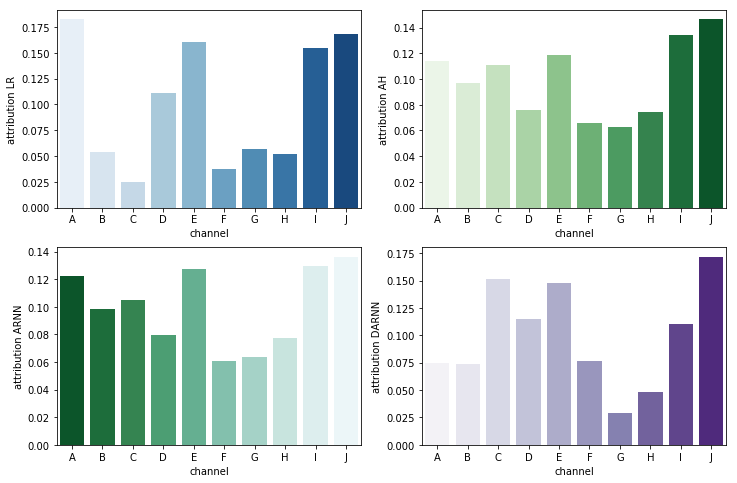

In [ ]:
f, axes = plt.subplots(2, 2, figsize=(12,8))

sns.barplot(x='channel', y='attribution LR', data=df, ax=axes[0,0], palette="Blues")
sns.barplot(x='channel', y='attribution AH', data=df, ax=axes[0,1], palette="Greens")
sns.barplot(x='channel', y='attribution ARNN', data=df, ax=axes[1,0], palette="BuGn_r")
sns.barplot(x='channel', y='attribution DARNN', data=df, ax=axes[1,1], palette="Purples")

plt.show()

---